In [19]:
import logging
import glob
from typing import List, Tuple, Union
from ast import literal_eval
import numpy as np
import cv2
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, HTML
from itertools import *
import os
import pandas as pd
import scipy.special as sc
import dotenv
import progressbar
import ffmpeg

dotenv.load_dotenv(dotenv.find_dotenv())
os.getcwd()

dotenv.find_dotenv()


'c:\\Users\\Shiqi Yang\\Documents\\GitHub\\nihmarmoset\\notebooks\\exploratory - Test\\.env'

In [20]:
print(f'  PROJECT_ROOT: {os.getenv("PROJECT_ROOT")}')
print(f'  PROJECT_DATA: {os.getenv("PROJECT_DATA")}')
print(f'PROJECT_MODELS: {os.getenv("PROJECT_MODELS")}')
print(f'    PYTHONPATH: {os.getenv("PYTHONPATH")}')
print(f'PYTHONBUFFERED: {os.getenv("PYTHONUBUFFERED")}')



  PROJECT_ROOT: C:/Users/Shiqi Yang/Documents/GitHub/nihmarmoset
  PROJECT_DATA: C:/Users/Shiqi Yang/Documents/GitHub/nihmarmoset/data
PROJECT_MODELS: C:/Users/Shiqi Yang/Documents/GitHub/nihmarmoset/models
    PYTHONPATH: C:/Users/Shiqi Yang/Documents/GitHub/nihmarmoset/src;c:\Users\Shiqi Yang\.vscode\extensions\ms-python.python-2020.10.332292344\pythonFiles;c:\Users\Shiqi Yang\.vscode\extensions\ms-python.python-2020.10.332292344\pythonFiles\lib\python
PYTHONBUFFERED: 1


In [21]:
def DataFileListbyType(tgtextlst,subdir):
    datdir = f'{os.getenv("PROJECT_DATA")}/{subdir}'
    #
    # Get list of subdirectories in subdir
    #
    subdirlst = next(os.walk(f'{datdir}'))[1]
    #
    # Initialize lists
    #
    fillst = []
    dirlst = []
    extlst = []
    #
    # iterate through subdirectories and find files that have extensions
    #
    for tmpdir in subdirlst:
        fullpath = f'{datdir}/{tmpdir}/'
        # used `glob` to allow for wildcards and avoid extraneous dotfiles
        dirlst = dirlst+[os.path.dirname(sub).replace(datdir,subdir) 
                         for sub in glob.glob(f'{datdir}/{tmpdir}/[0-9,a-z,A-Z]*.*') 
                         if os.path.splitext(sub)[1].replace('.','') in tgtextlst]
        fillst = fillst+[os.path.basename(sub) 
                         for sub in glob.glob(f'{datdir}/{tmpdir}/[0-9,a-z,A-Z]*.*') 
                         if os.path.splitext(sub)[1].replace('.','') in tgtextlst]
        extlst = extlst+[os.path.splitext(sub)[1].replace('.','') 
                         for sub in glob.glob(f'{datdir}/{tmpdir}/[0-9,a-z,A-Z]*.*') 
                         if os.path.splitext(sub)[1].replace('.','') in tgtextlst]
    datfildf = pd.DataFrame(data={"subdir":dirlst,"filename":fillst,"extension":extlst})
    return datfildf


def datfildf(fillst,typstr,rawsubdir):
    df = pd.DataFrame(fillst,columns=['raw_name'])
    df.insert(0,'raw_subdir',f'{rawsubdir}/{typstr}')
    df['raw_type'] = ''
    df['skiprowslist'] = ''
    df['header'] = ''
    df['ldmethod'] = ''
    for index, row in df.iterrows():
        extloc = row['raw_name'].find('.')
        extstr = row['raw_name'][extloc+1:]
        row['raw_type'] = typstr
        if row['raw_type'] == 'otu':
            row['skiprowslist'] = [1,2,3,4]
            row['header'] = [0,1,2,3,4]
        row['ldmethod'] = load_method_by_otu_type(extstr)
    return df


def cond_literal(str):
    return str if str == '' else literal_eval(str)


def getfilfromdf(indx,fildf):
    rawdir = f"{os.getenv('PROJECT_DATA')}/{fildf['raw_subdir'].iloc[indx]}"
    rawfilin = fildf['raw_name'].iloc[indx]
    return f'{rawdir}/{rawfilin}'

    
def gethdrrowsfromdf(indx,fildf):
    return fildf['header'].iloc[indx]

In [22]:
extsubdir = 'external/rgbda_record_data'
#extlst = ['mp4','avi','ogg','log']
extlst = ['avi']
datfildf = DataFileListbyType(extlst,extsubdir)

In [23]:
#display(HTML(datfildf.to_html()))
display(datfildf)

,subdir,filename,extension
0,external/rgbda_record_data/20170224,recording-2017-02-24_14_23_25.avi,avi
1,external/rgbda_record_data/20170224,recording-2017-02-24_14_26_16.avi,avi
2,external/rgbda_record_data/20171025,recording-2017-10-25_10_21_48.avi,avi
3,external/rgbda_record_data/20180803,recording-2018-08-03_10_24_57.avi,avi
4,external/rgbda_record_data/Test_data,Test.avi,avi


In [24]:
#display(HTML(datfildf.sort_values(by=['subdir']).to_html(index=False,notebook=True)))

In [25]:
#display((pd.MultiIndex.from_frame(datfildf)))

In [32]:
File_Index = 0

video_loc = f'{os.getenv("PROJECT_DATA")}/{datfildf.at[File_Index , "subdir"]}/{datfildf.at[File_Index , "filename"]}'
display(video_loc)

'C:/Users/Shiqi Yang/Documents/GitHub/nihmarmoset/data/external/rgbda_record_data/20170224/recording-2017-02-24_14_23_25.avi'





width: 640  height: 480
Number of frames: 1420





Video:
uint16
(3, 480, 640, 1)

Video_frame:
float64
(480, 640)
2.4082399653118496
0.0


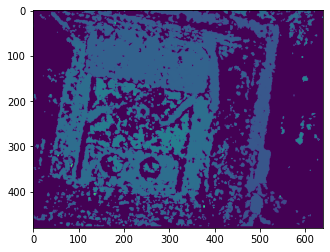

In [27]:


In_filename = 'recording-2017-02-24_14_23_25.avi'

probe = ffmpeg.probe(In_filename)

video_info = next(stream for stream in probe['streams'] if stream['codec_type']=='video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])

print('\n')
print('Number of frames: ' + str(num_frames) )
print('Size per frame:  '+'width: ' + str(width) + '  height: ' + str(height))
print('\n\n\n')


out, err = (
    ffmpeg
    .input(In_filename)
    #.output('pipe:', vframes=3, format = 'rawvideo', pix_fmt = 'rgb24') 
    .output('pipe:', format = 'rawvideo') # Extract all the frames from a video
    .output('pipe:', vframes=3, format = 'rawvideo') # Extract 3 frames from a video
    .run(capture_stdout=True)
)


#os.system('cls')

video = np.frombuffer(out, np.uint16)
# video = np.reshape(video, (-1, height, width, 3))
video = np.reshape(video, (-1, height, width, 1))
print('\nVideo:')
print(video.dtype)
print(video.shape)


# Display
video_frame = video[0,:,:,0]
video_frame = video_frame.astype(np.float64) # Convert from uint8 to float64
video_frame = video_frame / np.max(video_frame) * 255 + 1
video_frame = np.log10(video_frame)

print('\nVideo_frame:')
print(video_frame.dtype)
print(video_frame.shape)
print(np.max(video_frame))
print(np.min(video_frame))


plt.imshow(video_frame)
plt.show()


